In [80]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
from torchvision.utils import save_image
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image
from IPython.display import clear_output
import imageio
import glob
from tqdm import tqdm

Tensor = torch.Tensor

device = "cuda" if torch.cuda.is_available() else "cpu"

import torchvision.models as models
googlenet = models.googlenet(pretrained=True).to(device)
googlenet.eval();

c:\Users\mante\Documents\GitHub\audio-neural-dissection\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mante\Documents\GitHub\audio-neural-dissection\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [81]:
googlenet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [82]:
layer_out = None # ugly, we know

LAYER_OBJ = 1
CHANNEL_OBJ = 2
NEURON_OBJ = 3

class Objective():
    def __init__(self, obj_type, layer, **kwargs):
        self.type = obj_type
        self.layer = layer
        if obj_type == LAYER_OBJ:
            pass
        elif obj_type == CHANNEL_OBJ:
            self.channel_index = kwargs["channel_index"]
        elif obj_type == NEURON_OBJ:
            self.neuron_index = kwargs["neuron_index"]
        else:
            raise ValueError("`obj_type` must be one of LAYER_OBJ, CHANNEL_OBJ, NEURON_OBJ.")

def random_translation(offset, max_i, max_j, std=5):
    return [
        np.minimum(max_i, np.maximum(0, offset[0] + np.random.randn() * std)),
        np.minimum(max_j, np.maximum(0, offset[1] + np.random.randn() * std)),
    ]

def normalize(im):
    # im = im - torch.mean(im)
    # im = im / torch.std(im)/10
    # im += 0.5
    im -= torch.min(im)
    im /= torch.max(im) - torch.min(im)
    return im
    
class ActivationMaximizer():
    def __init__(self, model, input_shape):
        super().__init__()

        self.model = model
        self.input_shape = input_shape

    def plot_input(self, i, plot_period, save=False, plot_inline=False):
        im = np.array(self.input.data)[0]
        
        if plot_inline or save:
            plt.imshow(np.moveaxis(im, 0, -1))
            plt.title(f"Iteration: {i}")
            if save:
                plt.savefig(f"output/im{i//plot_period:04d}.png")
            if plot_inline:
                clear_output()
                plt.show()

    def optimize(self, objective, transforms=[], iterations=10, eta=1e-8, loss_func=None, reg=0, plot_period=None, save=False, plot_inline=False, start_image=None):
        larger_shape = list(self.input_shape)
        larger_shape[-1] = int(1.2 * larger_shape[-1])
        larger_shape[-2] = int(1.2 * larger_shape[-2])

        offset = [(larger_shape[-2] - self.input_shape[-2])//2, (larger_shape[-1] - self.input_shape[-1])//2]

        if start_image != None:
            start = start_image.reshape(larger_shape)
        else:
            start = torch.randn(larger_shape)*0.01 + 0.5

        self.input = torch.nn.Parameter(start.clone(), requires_grad=True)

        if start_image == None:
            for i in range(3, 40, 2):
                self.input.data = v2.GaussianBlur(i, sigma=(i/2, i/2))(self.input.data)

        loss_history = np.zeros(iterations)

        def hook(model, input, output):
            global layer_out
            layer_out = output
        
        objective.layer.register_forward_hook(hook)

        optimizer = torch.optim.Adam([self.input], eta)

        if loss_func == None:
            loss_func = lambda x: -torch.mean(x**2)

        for i in tqdm(range(iterations)):
            try:
                # Normalization
                self.input.data = normalize(self.input.data)

                # Plotting
                if plot_period != None and (i % plot_period == 0):
                    self.plot_input(i, plot_period, save=save, plot_inline=plot_inline)

                # External transforms
                for t in transforms:
                    self.input.data = t(self.input.data)

                # Cropping
                offset = random_translation(offset, larger_shape[-2] - self.input_shape[-2], larger_shape[-1] - self.input_shape[-1], std=20)
                i0, i1 = int(offset[0]), int(offset[0])+self.input_shape[-2]
                j0, j1 = int(offset[1]), int(offset[1])+self.input_shape[-1]
                cropped_input = self.input[..., i0:i1, j0:j1]

                # Optimization
                self.model.zero_grad()
                self.model.forward(cropped_input.to(device))

                if objective.type == LAYER_OBJ:
                    loss = loss_func(layer_out)
                elif objective.type == CHANNEL_OBJ:
                    mask = torch.zeros_like(layer_out)
                    mask[0, objective.channel_index, :, :] = 1
                    loss = loss_func(mask * layer_out)
                elif objective.type == NEURON_OBJ:
                    mask = torch.zeros_like(layer_out)
                    mask[0][objective.neuron_index] = 1
                    loss = loss_func(mask * layer_out)

                loss += torch.mean(self.input**2) * reg

                loss_history[i] = loss

                loss.backward()
                optimizer.step()
            except KeyboardInterrupt:
                print("Stopped before iteration", i)
                break

        return start, self.input, loss_history[:i]

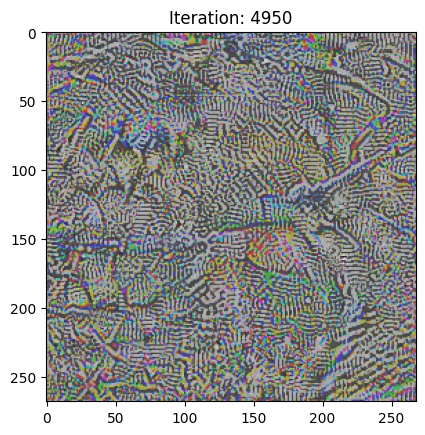

100%|██████████| 5000/5000 [04:31<00:00, 18.42it/s]


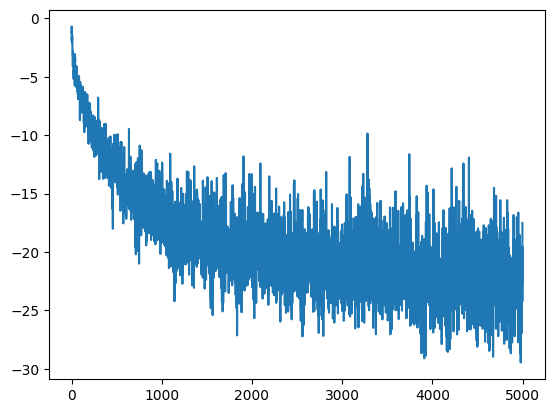

In [83]:
preprocess = v2.Compose([
    v2.Resize(224*2),
    v2.ToTensor()
])

transforms = [
    # v2.RandomAffine(0, translate=(0.01, 0.01)),
    # v2.RandomAffine(0, scale=(0.99, 1/0.99)),
    v2.RandomRotation(interpolation=v2.InterpolationMode.BILINEAR, degrees=(-0.1, 0.1)),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.GaussianBlur(5, sigma=(1, 2)),
    v2.ColorJitter(brightness=0.2, saturation=[0.8, 1.3], hue=0.1, contrast=[0.8, 1.3])
    # v2.RandomHorizontalFlip(),
    # v2.RandomVerticalFlip()
]

objective = Objective(NEURON_OBJ, googlenet.fc, neuron_index=594)
maximizer = ActivationMaximizer(googlenet, (1, 3, 224, 224))

start, result, loss_history = maximizer.optimize(
    objective=objective, 
    transforms=transforms, 
    iterations=5000,
    eta=100,
    loss_func=lambda x: -torch.sum(torch.abs(x)), #-torch.sum(x**2),
    reg=0,
    plot_period=50,
    save=True,
    plot_inline=True,
)

plt.figure()
plt.plot(loss_history)
plt.show()


In [85]:
images = []
file_names = glob.iglob("output/im*.png")
for f_name in file_names:
    images.append(imageio.imread(f_name))
imageio.mimsave("animated.gif", images)

C:\Users\mante\AppData\Local\Temp\ipykernel_23116\2391041340.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f_name))


In [ ]:
output = googlenet(result.to(device))

_, indices = torch.topk(output, 3)
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
for i in indices[0]:
    print(f"{i}: {percentage[i].item():.2f}%")

85: 8.13%
137: 7.13%
81: 6.98%


In [79]:
# import torch

# # Load pre-trained GoogleNet model

# import torchvision.models as models
# googlenet = models.googlenet(pretrained=True)
# googlenet.eval()

# # Set the model to evaluation mode


# # Load and preprocess an image for inference
# image_path = 'sax-test.jpg'
# input_image = Image.open(image_path)
# preprocess = transforms.Compose([
#     transforms.Resize(256),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
# input_tensor = preprocess(input_image)
# input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

# # Perform inference
# output = googlenet(input_batch)

# # Display the top 3 predictions
# _, indices = torch.topk(output, 3)
# percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
# for i in indices[0]:
#     print(f"{i}: {percentage[i].item():.2f}%")